# Fama French Factor Spreads

Yan Wu <br/>
yanwu26@gmail.com <br/>
3/20/2017

Fama French factors very well known systematic factors used in the investment management industry as risk factors in portfolio construction. They are momentum, value, size, profitability, and investment. This notebook shows the 10 year rolling annualized spread between the top decile and bottom decile groups within each factor. Essentially, this chart attempts to replicate the returns if we naively built a portfolio by longing the top decile and shorting the bottom decile, holding on the portfolio for 10 years, and annualizing the return.

We can observe that in the most recent history, the spreads have drastically collapsed.



In [307]:
import pandas as pd
import numpy as np
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from pandas_datareader import data as wb
from datetime import datetime, timedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from matplotlib.ticker import FuncFormatter 
%matplotlib inline
params = {'legend.fontsize': 'x-large','figure.figsize': (25, 10),'axes.labelsize': 'x-large','axes.titlesize':'x-large',
         'xtick.labelsize':'x-large','ytick.labelsize':'x-large'}#,'axes.facecolor': 'white'}
pylab.rcParams.update(params)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [314]:
def getFFcsv(file, cols, skip,n):
    url ='http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/'+file+'_CSV.zip'
    file= file+'.CSV'
    
    url = urlopen(url)
    zipfile = ZipFile(BytesIO(url.read()))
    df = pd.read_csv(zipfile.open(file), header = 0, nrows=n, names = cols, skiprows=skip).dropna()
    df['asof_dt'] = pd.to_datetime(df['asof_dt'], format = "%Y%m")
    df=df.set_index('asof_dt', drop=True)
    df=df.apply(pd.to_numeric, errors='ignore')/100 #convert to percentage
    
    #Get log returns
    df=np.log(1+df)
    
    #Calculate Spread
    df=df.rolling(120).sum().dropna() #10 year 
    df=np.exp(df/10) #annualized, back to geometric
    df['sp_1_10']=(df['10']-df['1'])
    return df


In [329]:
df_mom =getFFcsv('10_Portfolios_Prior_12_2',['asof_dt','1','2','3','4','5','6','7','8','9','10'], 11,1081)

df_bp  =getFFcsv('Portfolios_Formed_on_BE-ME',['asof_dt','l_0','lo_30','med_40','hi_30',
                                               'q1','q2','q3','q4','q5','1','2','3','4','5','6','7','8','9','10'],25,1087)

df_sz  =getFFcsv('Portfolios_Formed_on_ME',['asof_dt','l_0','lo_30','med_40','hi_30',
                                            'q1','q2','q3','q4','q5','1','2','3','4','5','6','7','8','9','10'],13,1087)

df_op  =getFFcsv('Portfolios_Formed_on_OP',['asof_dt','lo_30','med_40','hi_30',
                                            'q1','q2','q3','q4','q5','1','2','3','4','5','6','7','8','9','10'],19,643)

df_inv =getFFcsv('Portfolios_Formed_on_INV',['asof_dt','lo_30','med_40','hi_30',
                                            'q1','q2','q3','q4','q5','1','2','3','4','5','6','7','8','9','10'],19,643)

df=pd.concat([df_mom['sp_1_10'],df_bp['sp_1_10'],df_sz['sp_1_10'], df_op['sp_1_10'],df_inv['sp_1_10']],axis=1)
df.columns=[['Momentum','Value','Size','Profitability','Investment']]
df=df.dropna()

(array([ 48, 108, 168, 228, 288, 348, 408, 468, 528]),
 <a list of 9 Text xticklabel objects>)

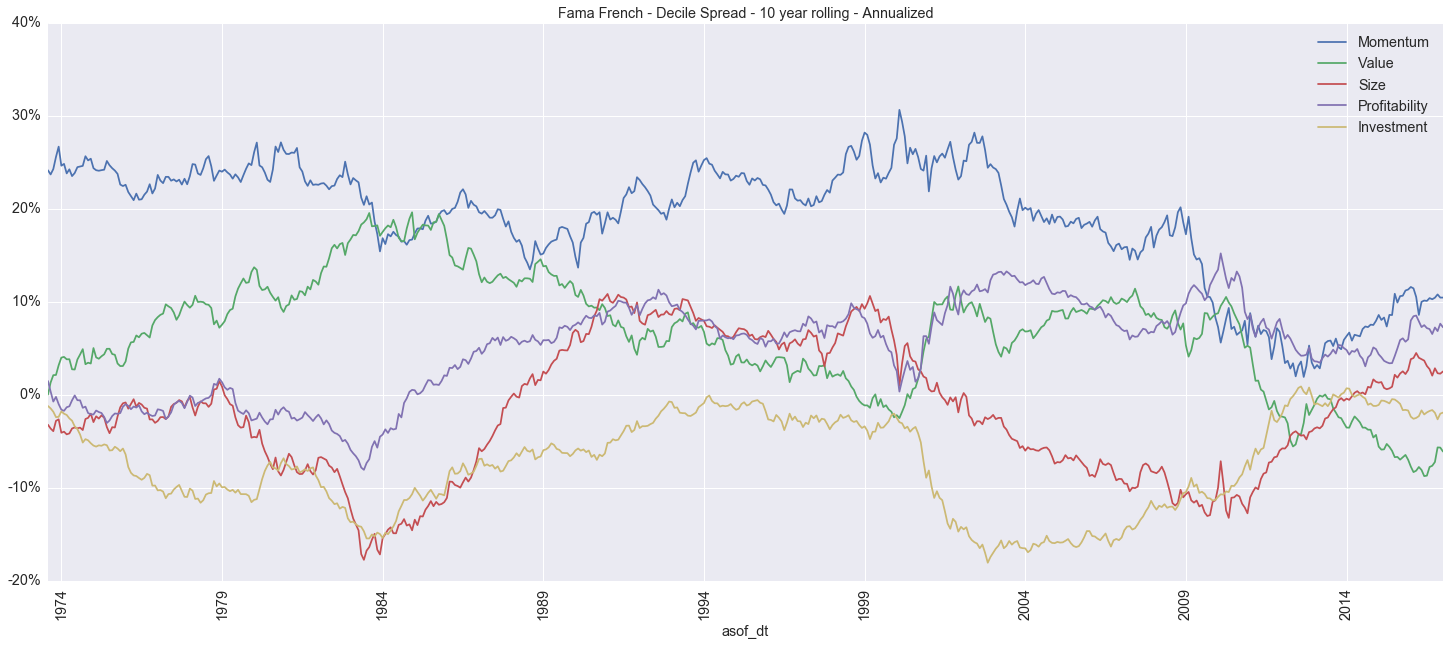

In [331]:
ax = df.plot()
#vals = ax.get_yticks()
ax=ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
plt.title('Fama French - Decile Spread - 10 year rolling - Annualized')
plt.xticks(rotation=90)